In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load and preprocess the data
df = pd.read_csv('../data/bintulu/bintulu-rainfall-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)
df.drop(columns=["TOTAL", "ClimAdjust", "Latitude", "Longitude", "Elevation"], inplace=True)

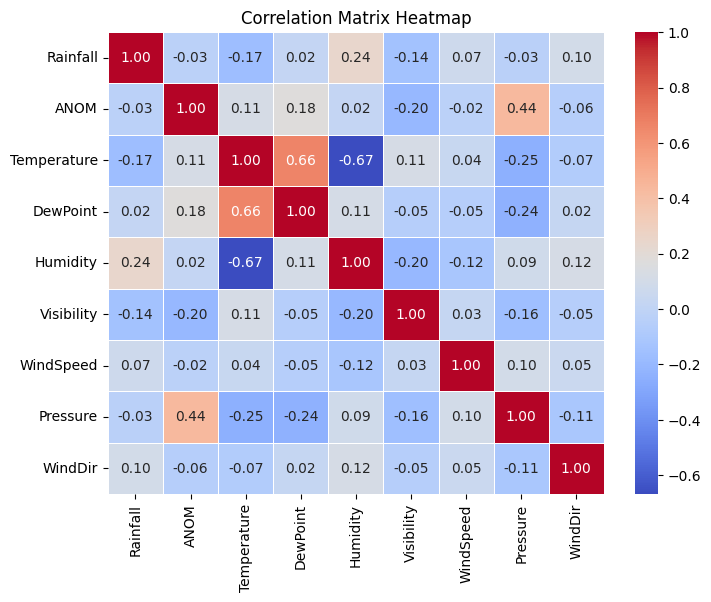

In [2]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [3]:
df

,Rainfall,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,,,
2012-01-01,55.4,-0.87,81.130435,77.434783,89.043478,6.000000,4.043478,29.816522,68.236934
2012-01-02,1.2,-0.87,79.863636,76.454545,89.590909,5.772727,3.727273,29.796364,77.457652
2012-01-03,3.4,-0.87,80.333333,76.333333,88.125000,6.000000,4.083333,29.788750,38.298448
2012-01-04,4.2,-0.87,78.458333,75.833333,92.208333,6.000000,3.250000,29.810000,111.273322
2012-01-05,88.0,-0.87,78.772727,75.272727,89.590909,5.300909,3.545455,29.807273,351.877250
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.8,-1.06,79.666667,74.166667,84.083333,6.000000,3.500000,29.777500,184.722626
2021-12-28,0.0,-1.06,80.583333,74.250000,82.666667,6.000000,3.166667,29.755417,111.540951
2021-12-29,0.6,-1.06,80.458333,73.666667,81.416667,5.875000,3.125000,29.743750,88.147018


In [4]:
# temporal features
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day_of_Year'] = df.index.dayofyear

def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df = cyclical_encode(df, 'Month', 12)
df = cyclical_encode(df, 'Day_of_Week', 7)
df = cyclical_encode(df, 'Day_of_Year', 366)
df.drop(['Month','Day_of_Week','Day_of_Year'], axis=1,inplace=True)

print(df.columns.to_list())
print(f"columns length after temporal features: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos']
columns length after temporal features: 15


In [5]:
# Define feature groups
interaction_features = {
    'Rainfall': ['Temperature', 'Humidity', 'Visibility', 'WindDir'],
    'Temperature': ['DewPoint', 'Humidity', 'Visibility', 'Pressure'],
    'Humidity': ['DewPoint', 'WindSpeed', 'WindDir'],
    'Visibility': ['WindSpeed', 'WindDir'],
    'WindDir': ['WindSpeed']
}

# Create interaction features
for feature, correlated_features in interaction_features.items():
    for correlated_feature in correlated_features:
        interaction_term = f'{feature}_{correlated_feature}'
        df[interaction_term] = df[feature] * df[correlated_feature]

df['Rainfall_Temperature_Humidity'] = df['Rainfall'] * df['Temperature'] * df['Humidity']
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Rainfall_Temperature', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindDir', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_Pressure', 'Humidity_DewPoint', 'Humidity_WindSpeed', 'Humidity_WindDir', 'Visibility_WindSpeed', 'Visibility_WindDir', 'WindDir_WindSpeed', 'Rainfall_Temperature_Humidity']
columns length after interaction: 30


In [6]:
df['DewPoint_Depression'] = df['Temperature'] - df['DewPoint']
df['WindDir_u'] = np.cos(np.radians(df['WindDir']))
df['WindDir_v'] = np.sin(np.radians(df['WindDir']))
df['Humidity_Pressure_Index'] = df['Humidity'] * (1/df['Pressure'])

In [7]:
print(df.columns.to_list())
print(f"columns length after interaction: {df.columns.size}")

['Rainfall', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir', 'Month_sin', 'Month_cos', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Rainfall_Temperature', 'Rainfall_Humidity', 'Rainfall_Visibility', 'Rainfall_WindDir', 'Temperature_DewPoint', 'Temperature_Humidity', 'Temperature_Visibility', 'Temperature_Pressure', 'Humidity_DewPoint', 'Humidity_WindSpeed', 'Humidity_WindDir', 'Visibility_WindSpeed', 'Visibility_WindDir', 'WindDir_WindSpeed', 'Rainfall_Temperature_Humidity', 'DewPoint_Depression', 'WindDir_u', 'WindDir_v', 'Humidity_Pressure_Index']
columns length after interaction: 34


In [8]:
for feat in ['Rainfall', 'Temperature', 'DewPoint', 'Humidity', 'Visibility', 'WindSpeed', 'Pressure']:
    for window in [3, 7]:
        df[f"{feat}_{window}d_avg"] = df[feat].rolling(window).mean()
        df[f"{feat}_{window}d_std"] = df[feat].rolling(window).std()
        df[f"{feat}_{window}d_sum"] = df[feat].rolling(window).sum()
        df[f"{feat}_{window}d_min"] = df[feat].rolling(window).min()
        df[f"{feat}_{window}d_max"] = df[feat].rolling(window).max()
        df[f"{feat}_{window}d_median"] = df[feat].rolling(window).median()

df.dropna(inplace=True)
print(f"columns length after rolling statistics: {df.columns.size}")

columns length after rolling statistics: 118


C:\Users\User\AppData\Local\Temp\ipykernel_13904\2256657539.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feat}_{window}d_sum"] = df[feat].rolling(window).sum()
C:\Users\User\AppData\Local\Temp\ipykernel_13904\2256657539.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{feat}_{window}d_min"] = df[feat].rolling(window).min()
C:\Users\User\AppData\Local\Temp\ipykernel_13904\2256657539.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [9]:
# Define features and target
target = 'Rainfall'
features = [col for col in df.columns if col != target]

# for feature in ['Temperature', 'Humidity', 'Pressure', 'WindSpeed', 'WindDir', 'Visibility', 'DewPoint']:
for feature in features:
    # Create all lag features for the current variable
    for i in range(1, 8):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

df.dropna(inplace=True)
print(f"columns length after lagged features: {df.columns.size}")

C:\Users\User\AppData\Local\Temp\ipykernel_13904\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_13904\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_13904\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

columns length after lagged features: 937


C:\Users\User\AppData\Local\Temp\ipykernel_13904\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_13904\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{i}'] = df[feature].shift(i)
C:\Users\User\AppData\Local\Temp\ipykernel_13904\289363806.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [10]:
# Get the number of null values for each column and sort them in descending order
null_counts = df.isna().sum().sort_values(ascending=False)

# Filter only columns that have null values (count > 0)
null_counts = null_counts[null_counts > 0]

if len(null_counts) > 0:
    print("Columns with null values:")
    print(null_counts)
else:
    print("No null values found in the dataset")

No null values found in the dataset


In [11]:
# Split the data
X = df[features]
y = df[target]

# Split into train and test sets
train_size = int(len(df) * 0.7)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Scale the data using RobustScaler
scaler_X = RobustScaler()
scaler_y = PowerTransformer(method='yeo-johnson')
# scaler_y = RobustScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
# model = Sequential([
#     LSTM(128, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
#     Dropout(0.4),
#     LSTM(64, activation='relu', return_sequences=True),
#     Dropout(0.3),
#     LSTM(32, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1)
#     ])

# Trial3
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.5),
    LSTM(64, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
model.summary()

# Train model
history = model.fit(
    X_train_reshaped, 
    y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.3,
    verbose=1
)

d:\rainfall-forecast\lstm\.virt\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       251,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,585 (1.33 MB)

 Trainable params: 347,585 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 3.3718 - val_loss: 2.8480
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7227 - val_loss: 2.2359
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0865 - val_loss: 1.5735
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4976 - val_loss: 1.1941
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1569 - val_loss: 0.9183
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8490 - val_loss: 0.7047
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6213 - val_loss: 0.5462
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4740 - val_loss: 0.4234
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3794 - val_loss: 0.3381
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3042 - val_loss: 0.2699
Epoch 11/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2525 - val_loss: 0.2233
Epoch 12/100
112/112 ━━━━━━━━━━━━━━━━━━━

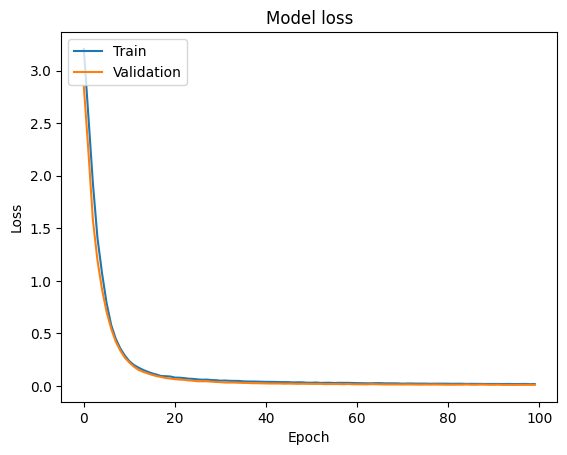

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE (Train): 2.179800203696661
MSE (Train): 57.27984520952887
RMSE (Train): 7.5683
R2 (Train): 0.8843483346147019
MAPE (Train): 15.3988%


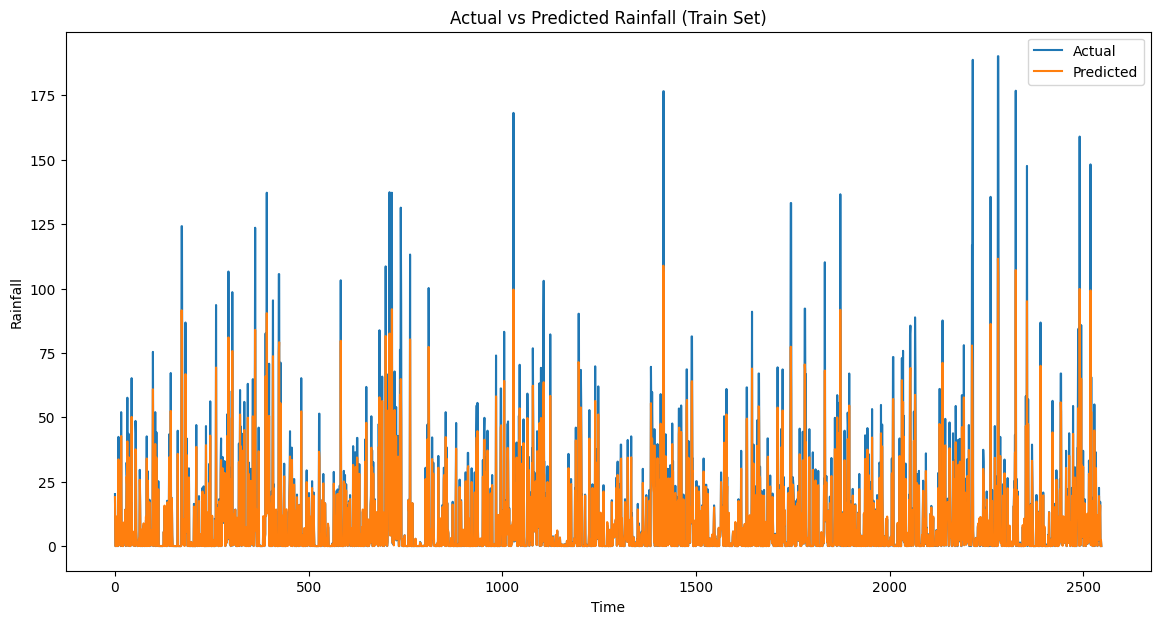

In [16]:
# Predict on the training set
y_train_pred_scaled = model.predict(X_train_reshaped)

# Inverse transform the scaled predictions and actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train_scaled)

# get the sample data into a dataframe
df_results = pd.DataFrame(y_train_actual, columns=['actual'])
df_results['predicted'] = y_train_pred

# Calculate evaluation metrics
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mse_train = mean_squared_error(y_train_actual, y_train_pred)  
rmse_train = np.sqrt(mse_train)  
r2_train = r2_score(y_train_actual, y_train_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle zero values in y_true to avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

print(f'MAE (Train): {mae_train}')
print(f'MSE (Train): {mse_train}')
print(f'RMSE (Train): {rmse_train:.4f}')
print(f'R2 (Train): {r2_train}')
print(f'MAPE (Train): {mape_train:.4f}%')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_train_actual, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Actual vs Predicted Rainfall (Train Set)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [14]:
print(df_results.describe())
print(df.shape)

            actual    predicted
count  2548.000000  2548.000000
mean     11.597253     9.604908
std      22.259234    16.025038
min       0.000000    -0.055543
25%       0.000000     0.047832
50%       1.600000     1.604816
75%      13.600000    13.521324
max     190.200000   111.573700
(3640, 937)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE (Valid): 2.1519012085657825
MSE (Valid): 59.60611436190435
RMSE (Valid): 7.5683
R2 (Valid): 0.8794243506793578
MAPE (Valid): 17.8234%


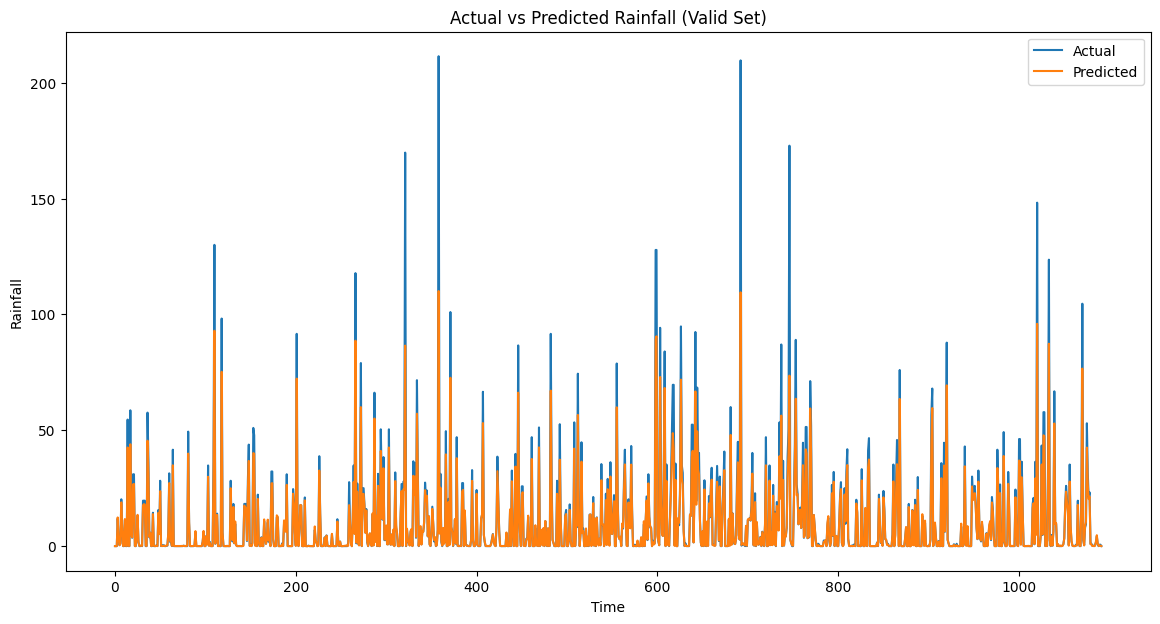

In [20]:
# Predict on the test set
y_test_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform the scaled predictions and actual values
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# get the sample data into a dataframe
df_results = pd.DataFrame(y_test_actual, columns=['actual'])
df_results['predicted'] = y_test_pred

# Calculate evaluation metrics
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
mse_test = mean_squared_error(y_test_actual, y_test_pred)  
rmse_test = np.sqrt(mse_train)  
r2_test = r2_score(y_test_actual, y_test_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle zero values in y_true to avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print(f'MAE (Valid): {mae_test}')
print(f'MSE (Valid): {mse_test}')
print(f'RMSE (Valid): {rmse_test:.4f}')
print(f'R2 (Valid): {r2_test}')
print(f'MAPE (Valid): {mape_test:.4f}%')

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Rainfall (Valid Set)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [18]:
print(df_results.describe())
print(df.shape)

            actual    predicted
count  1092.000000  1092.000000
mean     11.332967     9.365243
std      22.244085    15.834404
min       0.000000    -0.050521
25%       0.000000     0.054970
50%       1.400000     1.397019
75%      13.000000    13.051658
max     211.400000   110.069138
(3640, 937)


In [ ]:
model.save('LSTM1_trial3.h5')